Epoch 1/5
1875/1875 [==============================] - 46s 22ms/step - loss: 0.1277 - classification_loss: 0.1263 - bbox_loss: 0.0029 - classification_accuracy: 0.9624 - val_loss: 0.0463 - val_classification_loss: 0.0458 - val_bbox_loss: 9.8421e-04 - val_classification_accuracy: 0.9847
Epoch 2/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0431 - classification_loss: 0.0428 - bbox_loss: 5.7610e-04 - classification_accuracy: 0.9862 - val_loss: 0.0385 - val_classification_loss: 0.0383 - val_bbox_loss: 3.9468e-04 - val_classification_accuracy: 0.9867
Epoch 3/5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0306 - classification_loss: 0.0304 - bbox_loss: 2.5504e-04 - classification_accuracy: 0.9907 - val_loss: 0.0327 - val_classification_loss: 0.0327 - val_bbox_loss: 1.6308e-04 - val_classification_accuracy: 0.9897
Epoch 4/5
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0210 - classification_loss: 0.0209 - bbox_loss: 1.11

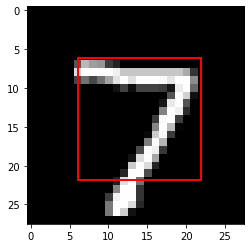

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # Load MNIST dataset
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0  # Normalize and reshape training data
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0    # Normalize and reshape test data

# 2. Generate synthetic bounding boxes for all images
bbox_train = np.array([[6, 6, 22, 22] for _ in range(len(x_train))], dtype=np.float32) / 28.0  # Bounding box for training set
bbox_test = np.array([[6, 6, 22, 22] for _ in range(len(x_test))], dtype=np.float32) / 28.0    # Bounding box for test set

# 3. Define the CNN model with two outputs (classification and bounding box prediction)
inputs = Input(shape=(28, 28, 1))                      # Input layer for 28x28 grayscale image
x = Conv2D(32, (3, 3), activation='relu')(inputs)      # First convolutional layer
x = MaxPooling2D((2, 2))(x)                            # First max-pooling layer
x = Conv2D(64, (3, 3), activation='relu')(x)           # Second convolutional layer
x = MaxPooling2D((2, 2))(x)                            # Second max-pooling layer
x = Flatten()(x)                                       # Flatten the output
x = Dense(128, activation='relu')(x)                   # Fully connected layer

classification_output = Dense(10, activation='softmax', name='classification')(x)  # Output layer for digit classification
bbox_output = Dense(4, activation='sigmoid', name='bbox')(x)                       # Output layer for bounding box prediction

model = Model(inputs=inputs, outputs=[classification_output, bbox_output])        # Create the model with two outputs

# 4. Compile and train the model
model.compile(
    optimizer='adam',  # Optimizer
    loss={'classification': 'sparse_categorical_crossentropy', 'bbox': 'mse'},  # Loss functions
    loss_weights={'classification': 1.0, 'bbox': 0.5},  # Relative weights for each output
    metrics={'classification': 'accuracy'}  # Evaluation metric
)

model.fit(
    x_train,
    {'classification': y_train, 'bbox': bbox_train},  # Training labels for both outputs
    epochs=5,  # Number of training epochs
    validation_data=(x_test, {'classification': y_test, 'bbox': bbox_test})  # Validation data
)

# 5. Save the trained model to a file
model.save('multi_output_mnist_model.h5')  # Save the entire model

# 6. Test the model on a single image
test_image = x_test[0:1]                            # Select one test image
class_pred, bbox_pred = model.predict(test_image)  # Predict class and bounding box
digit = np.argmax(class_pred[0])                   # Get the predicted digit
bbox = bbox_pred[0] * 28                            # Convert normalized bbox to pixel values

print(f"Predicted digit: {digit}")                  # Print predicted digit

# Plot the image and the predicted bounding box
fig, ax = plt.subplots()
ax.imshow(test_image[0].reshape(28, 28), cmap='gray')  # Show image in grayscale
rect = patches.Rectangle(
    (bbox[0], bbox[1]),          # Top-left corner of the box
    bbox[2] - bbox[0],           # Width of the box
    bbox[3] - bbox[1],           # Height of the box
    linewidth=2, edgecolor='r', facecolor='none'  # Red box with no fill
)
ax.add_patch(rect)  # Add the bounding box to the plot
plt.show()          # Display the plot
